# Focal loss 

*Focal loss* для решения задачи сегментации был предствален в статье https://arxiv.org/abs/1708.02002
и имеет вид: $$ $$

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [9]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
import blosc
import pickle

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import tqdm_notebook as tqn
from tensorflow.contrib.layers import xavier_initializer_conv2d
from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from focal_loss_batch import FocalBatch

In [10]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

In [11]:
import pandas as pd

In [12]:
data = pd.DataFrame(full_labs)

In [13]:
indices_non_zero = data[data[0] != 1.0].index.values
indices_zero =  data[data[0] == 1.0].index.values

In [74]:
indices_zero.shape

(6424,)

In [87]:
train_idx = np.hstack((indices_zero[:1000], indices_non_zero[:-5000]))

In [88]:
test_idx_nonzero = indices_non_zero[-5000:]

In [90]:
test_idx_zero = indices_zero[1000:]

In [91]:
test_idx_all = np.hstack((indices_zero[1000:], indices_non_zero[-5000:]))

In [92]:
len(test_idx_all)

10424

In [93]:
zero_test_data = [src[0][i] for i in test_idx_zero]

In [94]:
nonzero_test_data = [src[0][i] for i in test_idx_nonzero]

In [95]:
zero_test_labels = [src[1][i] for i in test_idx_zero]

In [96]:
nonzero_test_labels = [src[1][i] for i in test_idx_nonzero]

In [97]:
train_data = [src[0][i] for i in train_idx]

In [98]:
train_labels = [src[1][i] for i in train_idx]

In [99]:
ix = DatasetIndex(train_idx)
train_dataset = Dataset(ix, FocalBatch)

zero_test_ix = DatasetIndex(test_idx_zero)
zero_test_dataset = Dataset(zero_test_ix, FocalBatch)

nonzero_test_ix = DatasetIndex(test_idx_nonzero)
nonzero_test_dataset = Dataset(nonzero_test_ix, FocalBatch)

In [101]:
widening_factors = [3]
length_factors = [1]
add_blocks = [0]
gammas = [0.5, 1.0, 2.0, 5.0]

In [102]:
n_iterations = 400

In [104]:
losess_zero = defaultdict(list)
accs_zero = defaultdict(list)

train_times = defaultdict(list)
train_ppls = defaultdict(list)

losess_nonzero = defaultdict(list)
accs_nonzero = defaultdict(list)

In [28]:
for index, gamma in enumerate(gammas):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                    'factor':3, \
                    'length_factor':length_factors[0], \
                    'add_blocks':add_blocks[0], \
                       'gamma':gamma}}
    stats = []
    loss_history = []
    time_list = []

    ppl = (train_dataset.pipeline(config=config)
                        .train_res(loss_history, stats, src[0], full_labs, time_list, 1.0))

    current_loss_zero = []
    current_acc_zero = []
    zero_test_dataset = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss_zero, current_acc_zero, src[0],\
                                                                        full_labs, 1.0))
    
    
    
    print('current config', config['resnet']['factor'])


    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    print ('time ', np.mean(np.array(time_list)))
    
    test_losses_lengths['standardloss' + str(index)] = current_loss
    test_accs_lengths['standardloss' + str(index)] = current_acc
    train_times_lengths['standardloss' + str(index)] = time_list
    pipelines_dict_length['standardloss' + str(index)]  = ppl
    
    print('mean_acc: ', np.mean(np.array(current_acc[-100:])))
    
#     test_losses_lengths['standardloss'] = current_loss
#     test_accs_lengths['standardloss'] = current_acc
#     train_times_lengths['standardloss'] = time_list
#     pipelines_dict_length['standardloss']  = ppl

current config 3


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:17<00:00,  1.58it/s]


time  0.278215463864
mean_acc:  0.866
current config 3


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:14<00:00,  1.56it/s]


time  0.278460923429
mean_acc:  0.8576
current config 3


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:16<00:00,  1.58it/s]


time  0.279695990581
mean_acc:  0.8692
current config 3


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

48 48
[None, 7, 7, 48]
[None, 7, 7, 48]
96 96
[None, 7, 7, 96]
[None, 7, 7, 96]
192 192
[None, 7, 7, 192]
[None, 7, 7, 192]


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:16<00:00,  1.58it/s]


time  0.280168254022
mean_acc:  0.856


In [33]:
test_losses_lengths.keys()

dict_keys(['0', '1', '2', '7', '3', '4', '5', '6', '8', 'standardloss', 'standardloss+0', 'standardloss+1', 'standardloss+2', 'standardloss+3', 'standardloss+4', 'standardloss+5', 'standardloss0', 'standardloss1', 'standardloss2', 'standardloss3'])

In [37]:
train_times_lengths['standardloss+5'] = current_loss

In [32]:
train_times_lengths['standardloss+1']

[]

In [31]:
current_loss

[]

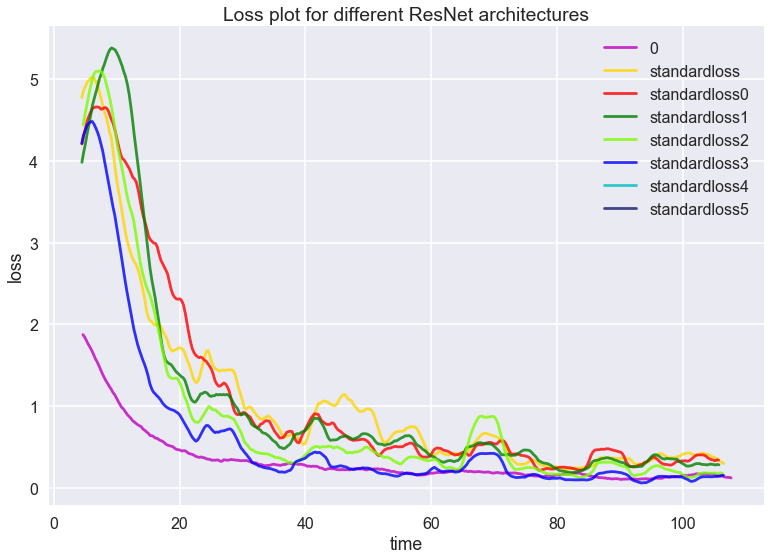

In [34]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different ResNet architectures')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue', 'y', 'cian']
# keys_300 = ['0+0', '22+0', '22+1']
# keys_300 = ['22+1', '22+2']
keys_300 = ['0', 'standardloss', 'standardloss0', 'standardloss1', 'standardloss2', 'standardloss3', 'standardloss4', \
            'standardloss5']
gammas = [0.0, 0.5, 1.0, 2.0, 5.0, 6.0]
for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_losses_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[15:len(smoothed_current)], smoothed_current[15:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

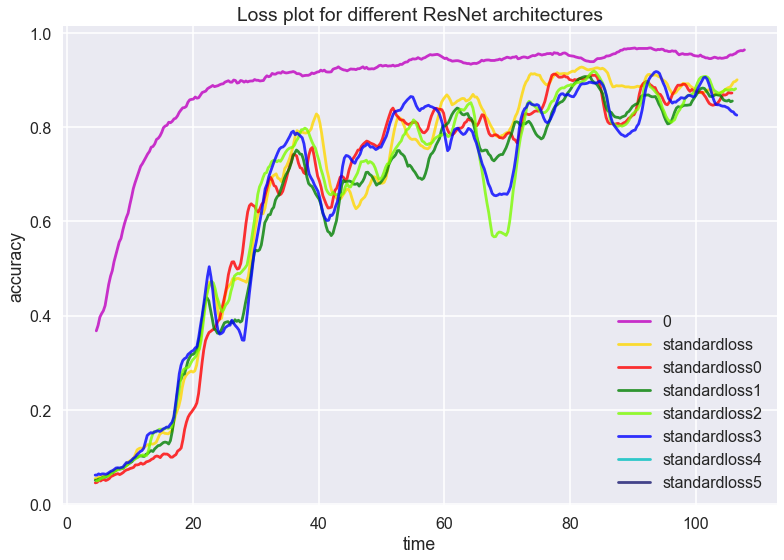

In [35]:
plt.style.use('seaborn-poster')
plt.title('Loss plot for different ResNet architectures')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' , 'c', 'midnightblue', 'y', 'cian']
# keys_300 = ['0+0', '22+0', '22+1']
# keys_300 = ['22+1', '22+2']
keys_300 = ['0', 'standardloss', 'standardloss0', 'standardloss1', 'standardloss2', 'standardloss3', 'standardloss4', \
            'standardloss5']

for index, current in enumerate(keys_300):
    current_time = np.cumsum(train_times_lengths[current])
    current_loss = test_accs_lengths[current]
#     if index < 6 and index >0:
#         continue
    smoothed_current = []
    for i in range(10, len(current_loss) - 10):
        smoothed_current.append(np.mean(current_loss[i-10:i+10]))

#     plt.plot(current_time[:], current_loss[:], c=cols[index], label = keys_300[index], alpha=0.8)
    plt.plot(current_time[15:len(smoothed_current)], smoothed_current[15:], c=cols[index], label = keys_300[index], alpha=0.8)

plt.legend()
plt.xlabel('time')
plt.ylabel('accuracy')
plt.show()

In [17]:
sess = tf.Session()
a = tf.constant(0.0)
b = tf.placeholder(tf.float32, shape=[1, 3])
c = tf.pow(b, a)
sess.run(tf.global_variables_initializer())
sess.run(c, feed_dict={b:[[1, 2, 3]]})

array([[ 1.,  1.,  1.]], dtype=float32)

# Save

In [25]:
with open("loss_results1.txt", "wb") as a:
    pickle.dump(test_losses_lengths, a)
    
with open("accs_results1.txt", "wb") as a:
    pickle.dump(test_accs_lengths, a)

with open("time_results1.txt", "wb") as a:
    pickle.dump(train_times_lengths, a)

# Load

In [27]:
with open("loss_results1.txt", "rb") as a:
    test_losses_lengths = pickle.load(a)
    
with open("accs_results1.txt", "rb") as a:
    test_accs_lengths = pickle.load(a)

with open("time_results1.txt", "rb") as a:
    train_times_lengths = pickle.load(a)
    
print('ok')

ok


In [21]:
test_accs_lengths.keys()

dict_keys(['0', '1', '2', '7', '8', '3', '4', '5', '6'])

In [30]:
sess = tf.Session()
a = 3
b = tf.constant(2)
c = a + b
sess.run(tf.global_variables_initializer())
sess.run(c)

5